# Predict Disaster Tweets using NLP

### Load required libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import contractions
import re
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
lemmatizer = WordNetLemmatizer()

In [2]:
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sns.set_style('darkgrid')
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
stopword = nltk.corpus.stopwords.words('english')

### Load helper functions

In [4]:
# helper functions
def tokenize(text):
    split=re.split("\W+",text) 
    return split

def remove_stopwords(text):
    text=[word for word in text if word not in stopword]
    return text

def remove_smallwords(text, length = 2):
    text=[word for word in text if len(word) > length]
    return text

def get_wordnet_pos(treebank_tag):
  """
  return WORDNET POS compliance to WORDENT lemmatization (a,n,r,v) 
  """
  if treebank_tag.startswith('J'):
      return wordnet.ADJ
  elif treebank_tag.startswith('V'):
      return wordnet.VERB
  elif treebank_tag.startswith('N'):
      return wordnet.NOUN
  elif treebank_tag.startswith('R'):
      return wordnet.ADV
  else:
      # As default pos in lemmatization is Noun
      return wordnet.NOUN

def wordnet_tagging(word):
  #word = list(word)
  postg = pos_tag(word)
  wntag = get_wordnet_pos(postg[0][1])
  return wntag

def countnonoverlappingrematches(pattern, thestring):
  return re.subn(pattern, '', thestring)[1]

### Load Input Data

In [5]:
train_file_path = '/content/drive/MyDrive/Kaggle/identify disaster tweets/train.csv'

In [6]:
train = pd.read_csv(train_file_path)

In [7]:
test_file_path = '/content/drive/MyDrive/Kaggle/identify disaster tweets/test.csv'

In [8]:
test = pd.read_csv(test_file_path)

In [9]:
train.shape

(7613, 5)

In [10]:
test.shape

(3263, 4)

In [11]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [12]:
test.shape

(3263, 4)

Adding NaN values in target column for test data which will help us to identify test set later

In [13]:
test['target'] = np.NaN

In [14]:
test.shape

(3263, 5)

In [15]:
data = pd.concat([train, test], axis=0)

In [16]:
data.shape

(10876, 5)

Let's view training data

In [17]:
data.reset_index(drop=True, inplace=True)

In [18]:
data.index

RangeIndex(start=0, stop=10876, step=1)

In [19]:
data.loc[100:116]

,id,keyword,location,text,target
100,144,accident,UK,.@NorwayMFA #Bahrain police had previously die...,1.0
101,145,accident,"Nairobi, Kenya",I still have not heard Church Leaders of Kenya...,0.0
102,146,aftershock,Instagram - @heyimginog,@afterShock_DeLo scuf ps live and the game... cya,0.0
103,149,aftershock,304,'The man who can drive himself further once th...,0.0
104,151,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/yN...,0.0
105,153,aftershock,304,'There is no victory at bargain basement price...,0.0
106,156,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0.0
107,157,aftershock,304,'Nobody remembers who came in second.' Charles...,0.0
108,158,aftershock,Instagram - @heyimginog,@afterShock_DeLo im speaking from someone that...,0.0
109,159,aftershock,304,'The harder the conflict the more glorious the...,0.0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


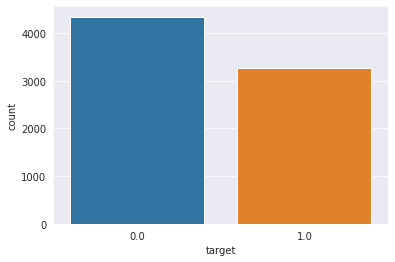

In [20]:
sns.countplot(data['target'])

In [21]:
print(data['target'].value_counts())
print(data['target'].value_counts(normalize=True))

0.0    4342
1.0    3271
Name: target, dtype: int64
0.0    0.57034
1.0    0.42966
Name: target, dtype: float64


In [22]:
data.isnull().sum()

id             0
keyword       87
location    3638
text           0
target      3263
dtype: int64

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10876 entries, 0 to 10875
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        10876 non-null  int64  
 1   keyword   10789 non-null  object 
 2   location  7238 non-null   object 
 3   text      10876 non-null  object 
 4   target    7613 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 425.0+ KB


### Checking effectiveness of Keyword column

In [24]:
#keyword_grp = data.groupby(['keyword']).agg({'id': 'count', 'target': 'sum'}).reset_index()

In [25]:
# keyword_grp.rename(columns={'id': 'keyword_count', 'target': 'target_count'}, inplace=True)
# keyword_grp['effectiveness'] = keyword_grp['target_count']/keyword_grp['keyword_count']

In [26]:
# keyword_grp.sort_values('effectiveness', ascending=False, inplace=True)

In [27]:
# keyword_grp.head(2)

### View random 10 tweets and their labels

In [28]:
# indx = np.random.randint(0, data.shape[0], 10)

In [29]:
indx = np.random.randint(0, data.shape[0], 10)
for i in indx:
  print("tweet index:{}".format(i))
  print("Tweet: {}".format(data.loc[i, 'text']))
  print("Tweet label: {}".format(data.loc[i, 'target']))
  print("-"*100)

tweet index:1238
Tweet: square just let booty org write xv im sure we'd do just fine (buildings around me set on fire)
Tweet label: 0.0
----------------------------------------------------------------------------------------------------
tweet index:10512
Tweet: Idk if ithats thunder or people rolling in their trashcans ??????
Tweet label: nan
----------------------------------------------------------------------------------------------------
tweet index:3769
Tweet: In the words of Charlie Daniels 'Fire on the mountain run boys run.'Û_ https://t.co/fz1HAEj255
Tweet label: 1.0
----------------------------------------------------------------------------------------------------
tweet index:5615
Tweet: Turkish newlyweds donate wedding money - what a beautiful gesture! Still have faith in humanity. http://t.co/o1eNHjrkJd
Tweet label: 0.0
----------------------------------------------------------------------------------------------------
tweet index:8523
Tweet: For everyone that doesn't know

Most of the tweets flaged as disaster are containing atleast one or two words which semantically relates to disaster like outbreak, thunder, terrorist, flood, terrorism.

### Trying to identify whether there is relation between **disaster tweets** and **number of links in the tweets**

Using regex to identify hyperink

In [30]:
hyperlink_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"

In [31]:
data['hyperlink'] = data['text'].apply(lambda x : countnonoverlappingrematches(hyperlink_regex, x))

In [32]:
data.tail()

,id,keyword,location,text,target,hyperlink
10871,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN,0
10872,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,NaN,0
10873,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,NaN,1
10874,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,NaN,1
10875,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...,NaN,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


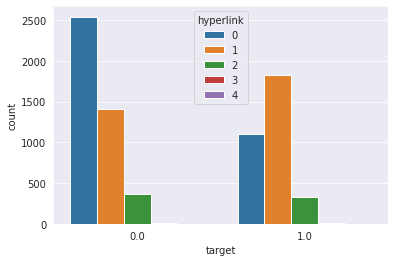

In [33]:
sns.countplot(data['target'], hue=data['hyperlink'])

In [34]:
#hyperlink = data.groupby(['target', 'hyperlink']).size().reset_index()
hyperlink = data.groupby(['target'])['hyperlink'].sum().reset_index()

In [35]:
hyperlink

,target,hyperlink
0,0.0,2204
1,1.0,2520


Disaster tweets are having more number of links compare to non-disaster tweets which does makes sense reason being people tend to attach video of natural calamities or another footage in order to make the tweet more factual

### Preprocessing the text now!

In [36]:
whitespace_pattern = re.compile(r'\s+')

In [37]:
def clean_text(text, hyperlink_regex):
  text = re.sub(hyperlink_regex, '', text)
  lower_text = str(text).lower()
  # text = contractions.fix(lower_text)
  return lower_text

def get_tokens(text):
  tokens = tokenize(text)
  tokens_wosw = remove_stopwords(tokens)
  tokens_wosmallwords = remove_smallwords(tokens_wosw)
  tweet = [lemmatizer.lemmatize(word, wordnet_tagging([word])) for word in tokens_wosmallwords]
  tweet = ' '.join(tweet)
  return tweet


In [38]:
data['keyword'].fillna('', inplace=True)

In [39]:
data['clean_keyword'] = data['keyword'].apply(lambda x : clean_text(x, hyperlink_regex))
data['clean_keyword'] = data['clean_keyword'].str.replace(r'[^a-zA-Z]',' ')
data['clean_keyword'] = data['clean_keyword'].apply(lambda x : get_tokens(x))

In [40]:
data['clean_text'] = data['text'].apply(lambda x : clean_text(x, hyperlink_regex))
data['clean_text'] = data['clean_text'].str.replace(r'[^a-zA-Z]',' ')
data['clean_text'] = data['clean_text'].apply(lambda x : get_tokens(x))

In [41]:
# dummy = {'user': ['user1', 'user2', 'user3'],
#          'message': ["Nobody remembers who came in second", "Aftershock was the most terrifying best rollercoaster ride I ever rode",
#                      "Remembering that you are going to die is the worst feeling"]}
# dummy = pd.DataFrame(dummy)                     
# dummy['clean_text'] = dummy['message'].apply(lambda x : clean_text(x, hyperlink_regex))
# dummy['clean_text'] = dummy['clean_text'].str.replace(r'[^a-zA-Z]',' ')
# dummy['clean_text'] = dummy['clean_text'].apply(lambda x : get_tokens(x))

In [42]:
data.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'hyperlink',
       'clean_keyword', 'clean_text'],
      dtype='object')

In [43]:
data.drop(['keyword', 'location', 'text', 'clean_keyword'], axis=1, inplace=True)

In [44]:
data.shape

(10876, 4)

### Applying TFiDF vectorizer

In [45]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(data['clean_text'])

In [46]:
X_array = pd.DataFrame(X.toarray())

In [47]:
df = pd.concat([X_array, data[['id', 'target']]], axis=1)

In [48]:
train_df = df[~df['target'].isnull()]
test_df = df[df['target'].isnull()]

In [49]:
y_train = train_df['target']

In [50]:
x_train = train_df.iloc[:, 0:17149]

In [51]:
x_test = test_df.iloc[:, 0:17149]

In [52]:
classifier = lgb.LGBMClassifier()
classifier.fit(x_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [53]:
y_pred = classifier.predict(x_test)
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# acc = accuracy_score(y_pred, y_test)
# report = classification_report(y_test, y_pred)
# print(report)
# cm = confusion_matrix(y_pred, y_test)
# sns.heatmap(cm, annot=True)
# print("Accuracy of LightGBM Model:", acc*100,"%")

In [54]:
y_pred.shape

(3263,)

In [55]:
y_pred

array([1., 1., 1., ..., 1., 1., 0.])

In [57]:
submission_file_path = '/content/drive/MyDrive/Kaggle/identify disaster tweets/sample_submission.csv'

In [58]:
submission = pd.read_csv(submission_file_path)

In [60]:
submission = pd.concat([submission, pd.DataFrame(y_pred)], axis=1)

In [61]:
submission.head()

,id,target,0
0,0,0,1.0
1,2,0,1.0
2,3,0,1.0
3,9,0,1.0
4,11,0,1.0


In [62]:
submission.drop('target', axis=1, inplace=True)

In [64]:
submission.rename({'0': 'target'}, inplace=True)

In [ ]:
export_path = '/content/drive/MyDrive/Kaggle/identify disaster tweets/'

In [65]:
submission.to_csv('/content/drive/MyDrive/Kaggle/identify disaster tweets/submission.csv')

Accuracy post kaggle submission: 78%

<https://www.kaggle.com/c/nlp-getting-started/leaderboard#score>